# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.slim as slim  # TensorFlow-Slim
from sklearn.model_selection import train_test_split

from io import BytesIO
from zipfile import ZipFile
import requests
import os
import time
import math

# Visualizations will be shown in the notebook.
%matplotlib inline

In [2]:
# Constants
NUMBER_OF_CLASSES = 43
IMAGE_SIZE = 32
NUMBER_OF_CHANNELS = 3

EPOCHS = 30 #40
BATCH_SIZE = 128
BATCH_SIZE_INF = 2048
VALIDATION_SIZE = 0.2

LEARNING_RATE = 0.001  #5e-3 # try 0.001 for ADAM
DROPOUT_KEEP = 0.5

MODEL_SAVE_PATH = "model.ckpt"

RESTORE = False  # restore previous model, don't train?
RESUME = False  # resume training from previously trained model?

In [3]:
def download_if_not_existing(file_url):
    if not os.path.isfile("data/test.p") or not os.path.isfile("data/train.p"):
        url = requests.get(file_url)
        zipfile = ZipFile(BytesIO(url.content))
        zipfile.extractall(path="data")
        print("data files downloaded and extracted")
    else:
        print("data file exist")

In [4]:
# Load pickled data

# TODO: Fill this in based on where you saved the training and testing data
%time download_if_not_existing("https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581faac4_traffic-signs-data/traffic-signs-data.zip")

training_file = "data/train.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

data file exist
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 148 µs
X_train shape: (39209, 32, 32, 3)
X_test shape: (12630, 32, 32, 3)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [5]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:3]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

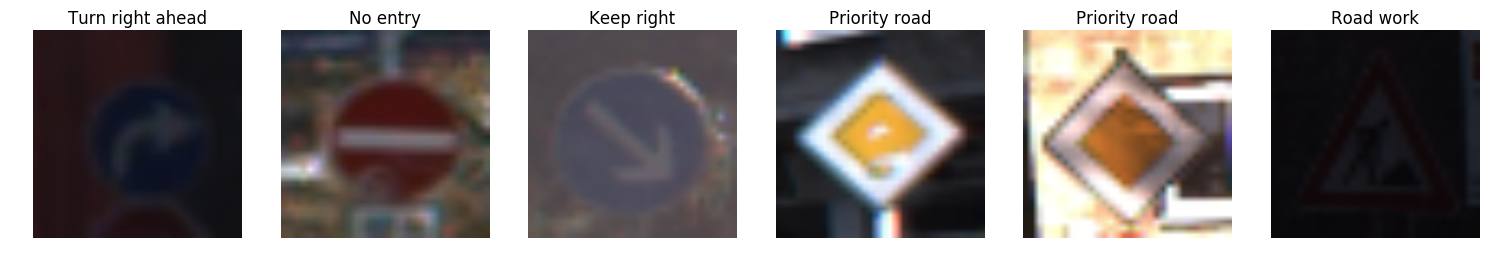

In [6]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# Read the sign names into a numpy array (note first row is col headings)
# By setting dtype to None, genfromtxt will try to automatically work
# out the data types - however for strings it gives byte sequences so 
# we convert them to strings when needed.
signnames = np.genfromtxt ("signnames.csv", delimiter=",", dtype=None)

# Pick a random sample of the training images
num_images_to_show = 6
indices = np.random.randint(0, n_train, num_images_to_show)
images = X_train[indices]
labels = y_train[indices]

plt.rcParams["figure.figsize"] = [15, 5]
plt.axis("off")  # clear x- and y-axes

for i, image in enumerate(images):
    plt.subplot(1, num_images_to_show, i+1)
    plt.axis("off")  # clear x- and y-axes
    plt.imshow(image)
    label_idx = labels[i]
    plt.title(signnames[label_idx+1][1].decode("utf-8"))
    
plt.tight_layout()

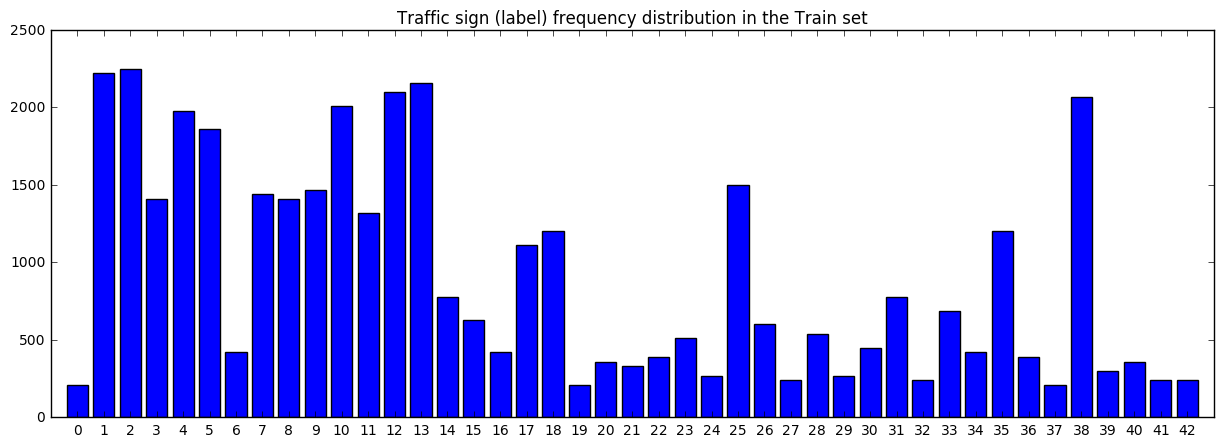

In [7]:
# Plot a bar chart of the label counts
# np.unique -> Returns the sorted unique elements of an array
labels, counts = np.unique(y_train, return_counts=True)

plt.figure()
axes = plt.gca()
axes.set_xlim([-1,43])
plt.bar(labels, counts, tick_label=labels, width=0.8, align="center")
plt.title("Traffic sign (label) frequency distribution in the Train set")
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [8]:
def preprocess(X, y):
    """
    Preprocess image data, and convert labels into one-hot

    Arguments:
        * X: Image data
        * y: Labels

    Returns:
        * Preprocessed X, one-hot version of y
    """
    # Convert from RGB to grayscale if applicable
    #if GRAYSCALE:
    #    X = rgb_to_gray(X)

    # Make all image array values fall within the range -1 to 1
    # Note all values in original images are between 0 and 255, as uint8
    X = X.astype("float32")
    X = (X - 128.) / 128.

    # Convert the labels from numerical labels to one-hot encoded labels
    y_onehot = np.zeros((y.shape[0], NUMBER_OF_CLASSES))
    for i, onehot_label in enumerate(y_onehot):
        onehot_label[y[i]] = 1.
    y = y_onehot

    return X, y

In [9]:
X_train, y_train = preprocess(X_train, y_train)
X_test, y_test = preprocess(X_test, y_test)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=VALIDATION_SIZE)

print("Train, Validation & Test data ready")

Train, Validation & Test data ready


In [10]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert inputs.shape[0] == targets.shape[0]
    
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
        
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
            
        yield inputs[excerpt], targets[excerpt]

In [11]:
def calculate_accuracy(inputs, targets, batch_size, accuracy, x, y, keep_prob, sess):
    """
    Helper function to calculate accuracy on a particular dataset
    """
    data_size = inputs.shape[0]
    num_batches = math.ceil(data_size / batch_size)
    last_batch_size = data_size % batch_size

    accs = []  # accuracy for each batch

    #for _ in range(num_batches):
    #    images, labels = next(data_gen)
    for batch in iterate_minibatches(inputs, targets, batch_size, shuffle=False):
        images, labels = batch
            
        # Perform forward pass and calculate accuracy
        # Note we set keep_prob to 1.0, since we are performing inference
        acc = sess.run(accuracy, feed_dict={x: images, y: labels, keep_prob: 1.})
        accs.append(acc)
        
    # Calculate average accuracy of all full batches (the last batch is the only partial batch)
    acc_full = np.mean(accs[:-1])
    
    # Calculate weighted average of accuracy accross batches
    acc = (acc_full * (data_size - last_batch_size) + accs[-1] * last_batch_size) / data_size
    
    return acc

In [12]:
def inference():
    """
    Define neural network architecture
    Return relevant tensor references
    """
    with tf.variable_scope('neural_network'):
        # Tensors representing input images and labels
        with tf.name_scope('input'):
            x = tf.placeholder('float', [None, IMAGE_SIZE, IMAGE_SIZE, NUMBER_OF_CHANNELS], name="images-input")
            y = tf.placeholder('float', [None, NUMBER_OF_CLASSES], name="labels-input")
            # Placeholder for dropout keep probability
            keep_prob = tf.placeholder(tf.float32, name="Dropout")

        # Neural network architecture: Convolutional Neural Network (CNN)
        # Using TensorFlow-Slim to build the network:
        # https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim

        # Use batch normalization for all convolution layers
        with slim.arg_scope([slim.conv2d], normalizer_fn=slim.batch_norm):
            # Given x shape is (32, 32, 3)
            # Conv and pool layers
            net = slim.conv2d(x, 16, [3, 3], scope='conv0')  # output shape: (32, 32, 16)
            net = slim.max_pool2d(net, [3, 3], 1, padding='SAME', scope='pool0')  # output shape: (32, 32, 16)
            net = slim.conv2d(net, 64, [5, 5], 3, padding='VALID', scope='conv1')  # output shape: (10, 10, 64)
            net = slim.max_pool2d(net, [3, 3], 1, scope='pool1')  # output shape: (8, 8, 64)
            net = slim.conv2d(net, 128, [3, 3], scope='conv2')  # output shape: (8, 8, 128)
            net = slim.conv2d(net, 64, [3, 3], scope='conv3')  # output shape: (8, 8, 64)
            net = slim.max_pool2d(net, [3, 3], 1, scope='pool3')  # output shape: (6, 6, 64)

            # Final fully-connected layers
            net = tf.contrib.layers.flatten(net)
            net = slim.fully_connected(net, 1024, scope='fc4')
            net = tf.nn.dropout(net, keep_prob)
            net = slim.fully_connected(net, 1024, scope='fc5')
            net = tf.nn.dropout(net, keep_prob)
            net = slim.fully_connected(net, NUMBER_OF_CLASSES, scope='fc6')

        # Final output (logits)
        logits = net

        # Loss (data loss and regularization loss) and optimizer
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
        #optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE).minimize(loss)
        optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)
        
        # Prediction (used during inference)
        predictions = tf.argmax(logits, 1)

        # Accuracy metric calculation
        correct_prediction = tf.equal(predictions, tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    # Return relevant tensor references
    return x, y, keep_prob, logits, optimizer, predictions, accuracy

In [13]:
print("Current settings:")
print("NUMBER_OF_CLASSES:", NUMBER_OF_CLASSES)
print("IMAGE_SIZE:", IMAGE_SIZE)
print("NUMBER_OF_CHANNELS:", NUMBER_OF_CHANNELS)
print("EPOCHS:", EPOCHS)
print("BATCH_SIZE:", BATCH_SIZE)
print("BATCH_SIZE_INF:", BATCH_SIZE_INF)
print("VALIDATION_SIZE:", VALIDATION_SIZE)
print("LEARNING_RATE:", LEARNING_RATE)
print("DROPOUT_KEEP:", DROPOUT_KEEP)
print("MODEL_SAVE_PATH:", MODEL_SAVE_PATH)
print("RESTORE:", RESTORE)
print("RESUME:", RESUME)

Current settings:
NUMBER_OF_CLASSES: 43
IMAGE_SIZE: 32
NUMBER_OF_CHANNELS: 3
EPOCHS: 30
BATCH_SIZE: 128
BATCH_SIZE_INF: 2048
VALIDATION_SIZE: 0.2
LEARNING_RATE: 0.001
DROPOUT_KEEP: 0.5
MODEL_SAVE_PATH: model.ckpt
RESTORE: False
RESUME: False


In [15]:
def save_model(saver, accuracy_history, sess):
    """
    Save model and accuracy data to disk (TF checkpoint)
    """
    save_path = saver.save(sess, MODEL_SAVE_PATH)
    print("Trained model saved at:", save_path)
    
    with open("accuracy_history.p", "wb") as f:
        pickle.dump(accuracy_history, f)

In [16]:
def train():
    """
    Perform inference (build the model) and train on the train dataset using
    minibatch gradient descent; saving results to a checkpoint file at each
    successive better vaidation accuracy result.
    """
    # Launch the graph
    with tf.Graph().as_default(), tf.Session() as sess:
        x, y, keep_prob, logits, optimizer, predictions, accuracy = inference()
        
        # TF saver to save/restore trained model
        saver = tf.train.Saver()

        if RESUME or RESTORE:
            print("Restoring previously trained model at %s" % MODEL_SAVE_PATH)
            # Restore previously trained model
            saver.restore(sess, MODEL_SAVE_PATH)

            # Restore previous accuracy history
            with open('accuracy_history.p', 'rb') as f:
                accuracy_history = pickle.load(f)

            if RESTORE:
                return accuracy_history
        else:
            print('Training model...')
            init = tf.global_variables_initializer()
            sess.run(init)

            # For book-keeping, keep track of training and validation accuracy over epochs, like such:
            # [(train_acc_epoch1, valid_acc_epoch1), (train_acc_epoch2, valid_acc_epoch2), ...]
            accuracy_history = []

        # Record time elapsed for performance check
        last_time = time.time()
        train_start_time = time.time()

        # Run EPOCHS epochs of training
        for epoch in range(EPOCHS):
            
            # Run training on each BATCH_SIZE minibatch
            for (images, labels) in iterate_minibatches(X_train, y_train, BATCH_SIZE, shuffle=False):
                # Perform gradient update (i.e. training step) on current batch
                sess.run(optimizer, feed_dict={x: images, y: labels, keep_prob: DROPOUT_KEEP})

            # Calculate training and validation accuracy across the *entire* train/validation set
            # If train/validation size % batch size != 0
            # then we must calculate weighted average of the accuracy of the final (partial) batch,
            # w.r.t. the rest of the full batches

            # Training set
            train_acc = calculate_accuracy(X_train, y_train, BATCH_SIZE_INF, accuracy, x, y, keep_prob, sess)
            
            # Validation set
            valid_acc = calculate_accuracy(X_valid, y_valid, BATCH_SIZE_INF, accuracy, x, y, keep_prob, sess)
                        
            # Record and report train/validation/test accuracies for this epoch
            accuracy_history.append((train_acc, valid_acc))

            # Print accuracy every 10 epochs
            #if (epoch+1) % 10 == 0 or epoch == 0 or (epoch+1) == EPOCHS:
            print('Epoch %d -- Train acc.: %.4f, Validation acc.: %.4f, Elapsed time: %.2f sec' %\
                (epoch+1, train_acc, valid_acc, time.time() - last_time))
            last_time = time.time()
            

        total_time = time.time() - train_start_time
        print('Total elapsed time: %.2f sec (%.2f min)' % (total_time, total_time / 60))

        # After training is complete, evaluate accuracy on test set - bring back last saved
        # checkpoint first, in case we stopped early.
        print("\nCalculating test accuracy...")
        test_acc = calculate_accuracy(X_test, y_test, BATCH_SIZE_INF, accuracy, x, y, keep_prob, sess)
        print("\nTest accuracy: %.4f" % (test_acc))

        save_model(saver, accuracy_history, sess)
                
    return accuracy_history
                
accuracy_history = train()

Training model...
Epoch 1 -- Train acc.: 0.0054, Validation acc.: 0.0051, Elapsed time: 19.18 sec
Epoch 2 -- Train acc.: 0.0054, Validation acc.: 0.0051, Elapsed time: 16.91 sec
Epoch 3 -- Train acc.: 0.0054, Validation acc.: 0.0051, Elapsed time: 16.92 sec
Epoch 4 -- Train acc.: 0.0054, Validation acc.: 0.0051, Elapsed time: 16.94 sec
Epoch 5 -- Train acc.: 0.0054, Validation acc.: 0.0051, Elapsed time: 16.96 sec
Epoch 6 -- Train acc.: 0.0054, Validation acc.: 0.0051, Elapsed time: 16.93 sec
Epoch 7 -- Train acc.: 0.0054, Validation acc.: 0.0051, Elapsed time: 16.94 sec
Epoch 8 -- Train acc.: 0.0054, Validation acc.: 0.0051, Elapsed time: 17.00 sec
Epoch 9 -- Train acc.: 0.0054, Validation acc.: 0.0051, Elapsed time: 16.93 sec
Epoch 10 -- Train acc.: 0.0054, Validation acc.: 0.0051, Elapsed time: 16.99 sec
Epoch 11 -- Train acc.: 0.0054, Validation acc.: 0.0051, Elapsed time: 16.99 sec
Epoch 12 -- Train acc.: 0.0054, Validation acc.: 0.0051, Elapsed time: 17.03 sec
Epoch 13 -- Train a

### Plot the training and validation

In [ ]:
print(tf.train.latest_checkpoint("/", MODEL_SAVE_PATH))

# Accuracy history has been saved as a List of Tuples
# Convert to numpy array - shape is EPOCHS x 2
# To plot this we transpose so that EPOCHS will be along X-axis

hist = np.transpose(np.array(accuracy_history))
plt.plot(hist[0], "b")  # training accuracy
plt.plot(hist[1], "r")  # validation accuracy
plt.title("Accuracy / Epoch (Training in blue and Validation in red)")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

Test accuracy 0.9602<br>
EPOCHS: 40<br>
BATCH_SIZE: 128<br>
BATCH_SIZE_INF: 2048<br>
VALIDATION_SIZE: 0.2<br>
LEARNING_RATE: 0.005<br>
DROPOUT_KEEP: 0.5<br>

Test accuracy 0.9538<br>
EPOCHS: 100<br>
BATCH_SIZE: 128<br>
BATCH_SIZE_INF: 2048<br>
VALIDATION_SIZE: 0.2<br>
LEARNING_RATE: 0.005<br>
DROPOUT_KEEP: 0.5<br>

* BEST *
Test acc.: 0.9624<br>
EPOCHS: 30<br>
BATCH_SIZE: 128<br>
BATCH_SIZE_INF: 2048<br>
VALIDATION_SIZE: 0.2<br>
LEARNING_RATE: 0.005<br>
DROPOUT_KEEP: 0.5<br>

Based on this more than 40 epochs is a waste at current settings is a waste - might pay to implement early stopping.

Changed to ADAM optimier but accuracy levels are terrible - need to change all params!

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In [ ]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.